# Convert cloud masking process graph to evalscript
Import the required processes and libraries. `from pg_to_evalscript import convert_from_process_graph` loads the library that this notebook is part of. 

In [1]:
import json

import openeo
from openeo.processes import ProcessBuilder, lt, if_
from pg_to_evalscript import convert_from_process_graph
from sentinelhub import BBox, CRS, DownloadRequest, SentinelHubDownloadClient, MimeType, SHConfig
import numpy as np
import matplotlib.pyplot as plt
import jsbeautifier

Connect to the openEO backend (2) and create a test polygon (3) and a datacube (4).

In [2]:
c = openeo.connect("https://openeo.vito.be/openeo/1.0")

In [3]:
test_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [12.481616, 42.016518],
            [12.437678, 41.995082],
            [12.542031, 41.942992],
            [12.632654, 41.971595],
            [12.620297, 42.002228],
            [12.481616, 42.016518],
        ]
    ],
}

In [4]:
def mask(value: ProcessBuilder):
    red = value.array_element(0)
    nir = value.array_element(1)
    clm = value.array_element(2)

    ndvi = (nir - red) / (nir + red)

    return if_(lt(clm, 40), ndvi)

sen2cor = c.load_collection(
    "SENTINEL2_L2A_SENTINELHUB", bands=["B04", "B08", "CLP"], temporal_extent=["2020-01-01", "2021-01-01"]
)
sen2cor_masked = sen2cor.reduce_dimension(dimension="bands", reducer=mask)
sen2cor_masked = sen2cor_masked.aggregate_spatial(test_polygon, reducer="median")
process_graph = json.loads(sen2cor_masked.to_json())["process_graph"]

Convert the process graph into an evalscript and print info about the created evalscript. The 'invalid_node_id' tells us up to which node the process graph could be converted. If it's "None", the whole process graph could be converted into an evalscript.

In [5]:
evalscripts = convert_from_process_graph(process_graph)
print(evalscripts)

[{'evalscript': <pg_to_evalscript.evalscript.Evalscript object at 0x000001E9F5CDFB50>, 'invalid_node_id': 'aggregatespatial1'}]


The output of `convert_from_process_graph` is a list of valid subgraphs. `aggregate_spatial` reduces by spatial coordinates, which is not possible with the SH Processing API because it works on a per pixel basis. Therefore, only an evalscript can be created for the process until the `aggregate_spatial` node.

In [6]:
evalscript = evalscripts[0]["evalscript"]
evalscript_string = evalscript.write()
print(jsbeautifier.beautify(evalscript_string))


//VERSION=3
function setup() {
  return {
    input: ['B04','B08','CLP'],
    output: { bands: 1, sampleType: "FLOAT32" },
    mosaicking: "ORBIT"
  };
}

function updateOutput(outputs, collection) {
    Object.values(outputs).forEach((output) => {
        output.bands = 1 + 1 * collection.scenes.length;
    });
}
class DataCube {
    constructor(data, bands_dimension_name, temporal_dimension_name, fromSamples) {
        this.TEMPORAL = "temporal"
        this.BANDS = "bands"
        this.OTHER = "other"
        this.bands_dimension_name = bands_dimension_name;
        this.temporal_dimension_name = temporal_dimension_name;
        this.dimensions = [{
            name: this.temporal_dimension_name,
            labels: [],
            type: this.TEMPORAL
        }, {
            name: this.bands_dimension_name,
            labels: [],
            type: this.BANDS
        }]
        if (fromSamples) {
            this.data = this.makeArrayFromSamples(data)
        } else {
            

## Check validity of the evalscript
Create SH request and send the created evalscript to SH, to confirm that a working script has been created (SH CLIENT_ID and CLIENT_SECRET have to be filled in).

In [7]:
config = SHConfig()
CLIENT_ID=""
CLIENT_SECRET=""
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

width = 100
height = 100
mimetype = MimeType.TIFF 
request_raw_dict = {
        "input": {
            "bounds": {
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/3857"},
                "bbox": [
            1369751.5468703588,
            5165920.119625352,
            1379535.486490861,
            5175704.059245855
         ],
            },
            "data": [
                {
                    "type": "S2L2A",
                    "dataFilter": {
                        "timeRange": {
                            "from":"2021-07-27T00:00:00.000Z",
                              "to":"2021-08-03T23:59:59.999Z"
                        },
                        "mosaickingOrder": "mostRecent",
                        "previewMode": "EXTENDED_PREVIEW",
                        "maxCloudCoverage": 100,
                    },
                    "processing": {"view": "NADIR"},
                }
            ],
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{"identifier": "default", "format": {"type": mimetype.get_string()}}],
        },
        "evalscript": evalscript_string,
    }


download_request = DownloadRequest(
    request_type="POST",
    url="https://services.sentinel-hub.com/api/v1/process",
    post_values=request_raw_dict,
    data_type=mimetype,
    headers={"content-type": "application/json"},
    use_session=True,
)

download_request.raise_if_invalid()

client = SentinelHubDownloadClient(config=config)
image = client.download(download_request)

In [8]:
decoding_function = evalscript.get_decoding_function()
decoded_image = decoding_function(image.tolist())

The returned data is in the format `[dim_size_1, ... , dim_size_n, val1, ... , val_m, ... empty_vals ...]`. The first `n` values refer to the sizes of each dimension, followed by the actual data, and possibly finally by some non-values. The latter are discarded and appear because we need to set the number of output bands before executing our process. Therefore, we use the upper estimate of the number of output bands.

`decoding_function` takes the data and reshapes it appropriately.

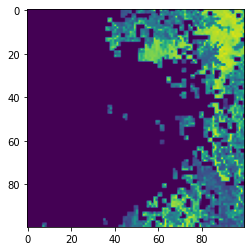

In [9]:
b = np.array(decoded_image)
plt.imshow(b[:,:,0:1])

The data obtained has, also a temporal dimension of length 4 in addition to the spatial dimension, sicne there are 4 dates with data in the area. Here we show the data of the first date.

The backend using this library should take this data and run it through its `aggregate_spatial` implementation.